<a href="https://colab.research.google.com/github/The-begining/sentimentAnalysis_amazonreview/blob/main/LSTM_sent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import SGD, Adam
import bz2
import csv
from sklearn.metrics import roc_auc_score

In [ ]:
# Load the training data
training_data = bz2.BZ2File("dataset\\train.ft.txt.bz2")
training_data = training_data.readlines()
training_data = [x.decode('utf-8') for x in training_data]
print(len(training_data))

# Load the test data
test_data = bz2.BZ2File("dataset\\test.ft.txt.bz2")
test_data = test_data.readlines()
test_data = [x.decode('utf-8') for x in test_data]
print(len(test_data))

3600000
400000


In [ ]:
#split the data into labels and texts
train_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]
train_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0])for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line)for line in test_data]

#convert labels to binary (0 and 1)
train_labels = [0 if label == 1 else 1 for label in train_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]

In [ ]:
def clean_text(text):
    #remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)

    #convert the text to lowercase
    text = text.lower()

    return text

In [ ]:
train_texts = pd.DataFrame(train_texts)[0].apply(clean_text)
test_texts = pd.DataFrame(test_texts)[0].apply(clean_text)

In [ ]:
pd.DataFrame(test_labels).value_counts()

0    1800000
1    1800000
dtype: int64

In [ ]:
len(train_texts)

400000

In [ ]:
len(test_texts)

3600000

In [ ]:
#tokenization and padding

max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [ ]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(train_labels)
print(y_train.shape)
y_test = np.array(test_labels)
print(y_test.shape)

(400000, 100)
(3600000, 100)
(400000,)
(3600000,)


In [ ]:
#create the  model

model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = 128))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units = 128))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 2, batch_size = 2048, verbose = 1, validation_split = .1)

Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.7348 - loss: 0.5127 - val_accuracy: 0.8837 - val_loss: 0.2762
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.8844 - loss: 0.2737 - val_accuracy: 0.8974 - val_loss: 0.2453


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

112500/112500 ━━━━━━━━━━━━━━━━━━━━ 12637s 112ms/step - accuracy: 0.8919 - loss: 0.2583
Loss:  0.2537897825241089
Accuracy:  0.8940427899360657


In [ ]:
prediction = model.predict(X_test)
y_pred = np.where(prediction>=.5, 1, 0)
df = pd.DataFrame()
df['actual'],df['pred'] = y_test, y_pred

 14783/112500 ━━━━━━━━━━━━━━━━━━━━ 114:32:29 4s/step

In [ ]:
df

,actual,pred
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1
...,...,...
399995,0,0
399996,0,0
399997,0,0
399998,1,1


array([[174268,  25732],
       [  9153, 190847]], dtype=int64)

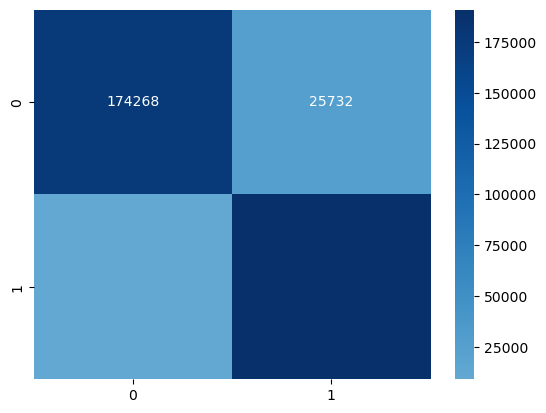

In [ ]:
import seaborn as sns
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM, annot = True, center = True, fmt = 'g', cmap = 'Blues')
CM


In [ ]:
report = classification_report(y_test, y_pred)
print("Classification Report: ")
print(report)

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91    200000
           1       0.88      0.95      0.92    200000

    accuracy                           0.91    400000
   macro avg       0.92      0.91      0.91    400000
weighted avg       0.92      0.91      0.91    400000

